In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline
plt.style.use("seaborn")
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy.signal import argrelextrema

### TODO
- Efficient
- clean
    - document
- extend residuals/predicted so can predict any date, not start and residuals divide by zero-padded array


In [2]:
data = pd.read_csv("./../datasets/Metro_time_series.csv")

In [3]:
LAST_DATE = '2006'
cols = ['Date', 'RegionName', 'ZHVI_AllHomes']
data = data[data['ZHVI_AllHomes'] > 0]
data = data.filter(cols)
data = data.rename(columns={"RegionName": "CBSA_Code"})

cityList = np.unique(data['CBSA_Code'])
metro = []
for code in tqdm(cityList):
    if min(data[data['CBSA_Code']  == str(code)].Date.values) <= LAST_DATE:
        metro.append(data[data['CBSA_Code']  == str(code)])
metro

100%|██████████| 730/730 [00:24<00:00, 30.00it/s]


   47700       143000.0
 211139  2017-12-31     47700       144100.0
 
 [261 rows x 3 columns],
               Date CBSA_Code  ZHVI_AllHomes
 650     1996-04-30     47780        61300.0
 1337    1996-05-31     47780        61900.0
 2025    1996-06-30     47780        61500.0
 2714    1996-07-31     47780        60400.0
 3403    1996-08-31     47780        60000.0
 ...            ...       ...            ...
 207496  2017-08-31     47780       114000.0
 208407  2017-09-30     47780       114200.0
 209318  2017-10-31     47780       114400.0
 210229  2017-11-30     47780       114200.0
 211140  2017-12-31     47780       113800.0
 
 [261 rows x 3 columns],
               Date CBSA_Code  ZHVI_AllHomes
 651     1996-04-30     47900       154200.0
 1338    1996-05-31     47900       154200.0
 2026    1996-06-30     47900       154400.0
 2715    1996-07-31     47900       154500.0
 3404    1996-08-31     47900       154200.0
 ...            ...       ...            ...
 207498  2017-08-31   

In [4]:
from sklearn.preprocessing import StandardScaler

def standardize(metro):
    scaler = StandardScaler()
    train = metro.ZHVI_AllHomes.values.reshape(-1, 1)
    return scaler.fit_transform(train)

for i in tqdm(metro):
    i['ZHVI_std'] = standardize(i) 

100%|██████████| 653/653 [00:01<00:00, 430.03it/s]


In [5]:
#metro

In [6]:
def movingAverage_normalize(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    moving_avg = ret[n - 1:] / n
    return np.array([(x-np.mean(moving_avg))/np.std(moving_avg) for x in moving_avg])
#fig, ax = plt.subplots()
#ax.scatter(pd.to_datetime(city1['Date'][4:]).dt.date, movingAverage_normalize(city1['ZHVI_AllHomes'].values))
#plt.show()
movingAverage_normalize(city1['ZHVI_AllHomes'].values)
# don't send moving average 
#  CHECK IF AFFECTS MOVING AVERAGE AFFECTS ARIMA

NameError: name 'city1' is not defined

Date CBSA_Code  ZHVI_AllHomes
316     1996-04-30     29420        85700.0
1002    1996-05-31     29420        85000.0
1689    1996-06-30     29420        84700.0
2378    1996-07-31     29420        84300.0
3067    1996-08-31     29420        84200.0
...            ...       ...            ...
207073  2017-08-31     29420       183800.0
207984  2017-09-30     29420       184500.0
208895  2017-10-31     29420       185500.0
209806  2017-11-30     29420       187300.0
210717  2017-12-31     29420       188900.0

[261 rows x 3 columns]


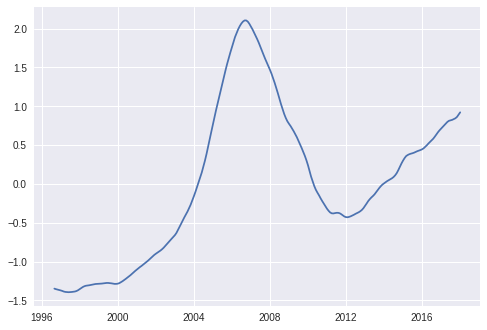

In [36]:
city1 = metro[0]
ames = data[data.CBSA_Code == '29420']
print(ames)
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(ames['Date'][4:]).dt.date, movingAverage_normalize(ames['ZHVI_AllHomes'].values))
# ax.scatter(pd.to_datetime('2009-05-31'), ames[ames['Date'] == '2009-05-31']['ZHVI_AllHomes'])

In [37]:
THRESHOLD = 1

# def find_max_start(city):
#     return type == str

def find_start(city):
    """
    returns recession start date, measured as the largest local maximum ZHVI for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm]
    returns: start_date (pd.datetime)
    """
    last_date = city.sort_values('Date', ascending=False).iloc[0]['Date']
    city = city[city['Date'] < '2015']
    d = lambda i: city['ZHVI_std'].iloc[i] - city['ZHVI_std'].iloc[i-1]
    diffs = np.array([d(i) for i in range(1, len(city))])
    # reshape dataframe to include diffs
    city = city.iloc[1:]
    city['Diffs'] = diffs
    # find local maxes using diffs
    is_max = np.array([(city['Diffs'].iloc[i] >= 0) 
                       and (city['Diffs'].iloc[i+1] <= 0) 
                       and (city['Diffs'].iloc[i+1] - city['Diffs'].iloc[i] <= THRESHOLD) for i in range(len(city) - 1)])
    is_max = np.append(is_max, False)

    # check for presence of local maxes at all
    if np.count_nonzero(is_max) == 0:
        return last_date
    # add 'is_maximum' truth column to dataframe
    city['Max'] = is_max
    # filter and find largest max
    theMax = city[city['Max'] == 1.0].sort_values("ZHVI_std", ascending=False).iloc[0]
    start_date = theMax['Date']
    return start_date

In [38]:
THRESHOLD = -0.002

def my_min(city_df):
    """
    """
    my_zhvi = city_df['ZHVI_std'].to_numpy()

    min_indeces = argrelextrema(my_zhvi, np.less)[0]
    min_vals = [my_zhvi[val] for val in min_indeces]
    min_dates = [city_df['Date'].to_numpy()[val] for val in min_indeces]


    curr_index = 0

    for i in range(len(min_vals)):
        if i == len(min_vals) - 1:
            curr_index = len(min_vals) - 1
            break
        else:
            if np.diff([min_vals[i], min_vals[i + 1]]) <= THRESHOLD: curr_index += 1
            else:
                curr_index = i
                break

    return min_dates[curr_index]

In [39]:
failed_cities = []
def ARIMA_50(city, start, params=(5,1,1)):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    start -- datetime object from index of city representing peak ZHVI
    params -- p, d, and q parameters for ARIMA
    """
    
    #add start.dt.strftime('%Y-%m-%d') to convert datetime to string
    
    from statsmodels.tsa.arima_model import ARIMA
    
    before = city[['Date', 'ZHVI_std']]

    before = before[before['Date'] < start].set_index(['Date'])['ZHVI_std'].values

    # Number of points for ARIMA to predict is length of original city df minus start indexed df
    steps = city.shape[0] - before.shape[0]

    # Try to fit arima model, except if no convergence add to list of failed cities
    try:
        model = ARIMA(before, order=(5, 1, 1))
        model_fit = model.fit(disp=0)
        return model_fit.forecast(steps)[0]
    except:
        failed_cities.append(np.unique(city.CBSA_Code)[0])
        return np.repeat(city[city['Date'] == start].ZHVI_AllHomes, steps)

In [40]:
def find_end(dataframe, residuals):
    """
    Finds end date by calculating residuals between predicted and actual values, then finding most recent positive residual
    returns recession end date, measured as the first point of intersection between ZHVI and ARIMA_50 for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm], ARIMA_50 (pd.dataframe) [Date, forecasted_ZHVI_norm] 
    returns: end_date (pd.datetime)
    """

    # calculate residual between predicted value and actual ZHVI value
    # TODO FIX RESIDUALS SO HAS INDEX OF DATES.
    dates = dataframe[dataframe['Date'] >= start]['Date'].values
    city_resid = pd.DataFrame(data={'Date': dates, 'Delta': residuals}) # each on sep line, better yet make numpy array w/ date index

    # filter only positive residuals, and most recent one is the last recession date
    most_recent_positive_delta = city_resid[city_resid['Delta'] > 0].sort_values("Date", ascending=False)

   # if ARIMA model indicates a sharp drop, set end date as one month after start date
   # TODO THIS SHOULD BE HANDLED BY PREDICTOR FUNCTION
    if (most_recent_positive_delta.shape[0] == 0):
        return city_resid.Date.values[0] # TODO WHY RETURN 0? NOT SHFITED +1?

        
    end_date = most_recent_positive_delta['Date'].iloc[0]
    
    return end_date

In [41]:
# TODO Altenative: have residuals array calculated, then final function sums residuals to end

In [42]:
def calculate_residuals(dataframe, predicted, start):
    """
    """
    # get data after start
    actual = dataframe[dataframe['Date'] >= start].values
    
    return actual - predicted

In [43]:
def calculate_area(residuals, start, end, return_resids=False):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    predicted -- predicted values from max to last date of city time-series
    max -- datetime object from index of city representing peak ZHVI
    end -- datetime object from index of city representing intersection of 
    actual and predicted ZHVI or last date of actual
    """

    # filter residuals between start and end
    filtered_residuals = residuals[(residuals['Date'] >= start) &
    (residuals['Date'] < end)]

    if return_residuals:
        return (np.sum(filtered_residuals), filtered_residuals)

    return np.sum(filtered_residuals)

In [44]:
def find_AU3(dataframe, predictor=ARIMA_50, start=None, end=None, return_resids=False, return_dates=False, plot=False, time=False):
    """
    Takes dataframe with CBSA codes, ZHVI values and name of city
    start: manual specified start date
    end: manual specified end date
    returns: Area between predicted and actual ZHVI values from start to end of recession
    """
    # TODO DOCSTRING and doctest?

    start_date = my_min(dataframe)

    predicted_values = predictor(dataframe, start_date)
    
    residuals = calculate_residuals(dataframe, predicted_values, start_date)

    end_date = find_end(dataframe, start_date, arima)

    if return_dates:
        return calculate_area(residuals, start_date, end_date, return_resids=return_resids), start, end


    return calculate_area(residuals, start, end, return_resids=return_resids)

In [45]:
#metro[0]
find_AU3(metro[1], residuals=True)

TypeError: find_AU3() got an unexpected keyword argument 'residuals'

In [ ]:
import myAU3
import sys
sys.path.append('..')

In [47]:

#AU3.find_AU3_1(metro[1], residuals=True)
# metro[0] start = end
myAU3.hello_world()


hello world


In [48]:
AU3_output = list(map(find_AU3, tqdm(metro)))

0%|          | 0/653 [00:01<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (214,4) (214,) 

In [ ]:
failed_cities

In [ ]:
adjusted_outputs = [np.log(i) if i > 0 else i for i in np.abs(AU3_output)]
plt.hist(adjusted_outputs)
max(adjusted_outputs), min(adjusted_outputs)

In [ ]:
cbsa_codes = [m['CBSA_Code'].iloc[0] for m in metro]

final_metro = pd.DataFrame(data={"CBSA_Codes": cbsa_codes, "AU3": adjusted_outputs})
final_metro.to_csv("AU3_results.csv")

In [ ]:
final_metro.sort_values('AU3', ascending=True)

In [ ]:
final_metro.sort_values('AU3', ascending=False)

In [ ]:
df = pd.DataFrame({"Date": [], "CBSA_Code": [], "ZHVI_AllHomes": [], "ZHVI_std": []})
for i in tqdm(metro):
    df = df.append(i)

In [ ]:
df.to_csv("./datasets/normed_ZHVI.csv")

## Everything below this cell is experimental/debugging

In [ ]:
# RANDOM STUFF DELETE LATER

from statsmodels.tsa.arima_model import ARIMA
city1.tail()
before = city1[['Date', 'ZHVI_AllHomes']][city1['Date'] < '2017-08-31'].set_index(['Date'])['ZHVI_AllHomes']
model = ARIMA(endog=np.array(before, dtype=np.float), order=(5, 1, 1))
model_fit = model.fit(disp=0)
#np.array(before, dtype=np.float)[0]
#city1['dt'] = city1
#np.array(city1['Date'], dtype='datetime64')
model_fit.predict(before.shape[0], city1.shape[0])

In [ ]:
city1 = city1[city1['Date'] < "2012"]
d = lambda i: city1['ZHVI_AllHomes'].iloc[i] - city1['ZHVI_AllHomes'].iloc[i-1]
diffs = np.array([d(i) for i in range(1, len(city1))])
# reshape dataframe to include diffs
city1 = city1.iloc[1:]
city1['Diffs'] = diffs
city1['Diffs']
# find local maxes using diffs
is_max = np.array([(city1['Diffs'].iloc[i] >= 0) and (city1['Diffs'].iloc[i+1] <= 0) for i in range(len(city1) - 1)])
is_max = np.append(is_max, False)

# check for presence of local maxes at all
if np.count_nonzero(is_max) == 0:
    print(0)
# add 'is_maximum' truth column to dataframe
city1['Max'] = is_max
# filter and find largest max
theMax = city1[city1['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
start_date = theMax['Date']
start_date

In [58]:
# Lucas

city1 = metro[0]
find_AU3(city1)

ValueError: operands could not be broadcast together with shapes (214,4) (214,) 

In [65]:
%load_ext autoreload
%autoreload 2
import module as mod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
mod.hello_world()

hello world


In [ ]:
city1 = metro[0]
city1['Date'] = pd.to_datetime(city1['Date'], format='%Y-%m-%d')
city1['Date'].nunique(), city1.shape[0]
city1.index = city1['Date']

In [68]:
ser1 = city1['ZHVI_std']
ser1

Date
1998-02-28   -1.632786
1998-03-31   -1.581558
1998-04-30   -1.484225
1998-05-31   -1.407382
1998-06-30   -1.356154
                ...   
2017-08-31    1.799503
2017-09-30    1.886591
2017-10-31    1.948065
2017-11-30    2.019784
2017-12-31    2.101749
Name: ZHVI_std, Length: 239, dtype: float64

/home/freebreadstix/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/home/freebreadstix/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


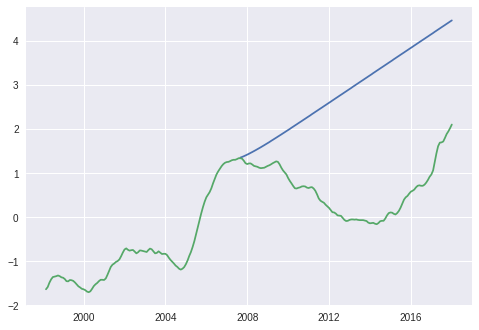

In [95]:
predicted = mod.ARIMA(ser1, mod.find_start(ser1))
start = mod.find_start(ser1)
residuals = (ser1 - predicted).dropna()
plt.plot(predicted)
plt.plot(ser1)

In [99]:
mod.find_AU3(ser1)

/home/freebreadstix/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/home/freebreadstix/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


278.8610870430933